In [52]:
import pandas as pd
import json
import time
import numpy as np
from google_currency import convert 

# Dataframe creation

In [2]:
data = pd.read_csv('/Users/mikel/Documents/Projects/chameleon-pricing/twb_data.csv', sep=",", skiprows=3)

In [3]:
data=data.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 65'])

In [4]:
data=pd.DataFrame(data.T)

In [5]:
indice = data.index[1:]

In [6]:
aux = pd.DataFrame(data.iloc[0])

In [7]:
final = pd.DataFrame(data = data.iloc[1:], index = indice, columns= list(aux['Country Name']))

In [8]:
last = data.iloc[1:]

In [9]:
df=last.rename(columns=dict(data.iloc[0]))

In [10]:
#Quitamos todas aquellas columnas y filas con full nulls
df=df.dropna(axis = 0, how = 'all')
df=df.dropna(axis = 1, how = 'all')

In [11]:
#fill old null values with first occurrence
df=df.fillna(method='backfill')

# Time series

In [13]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pylab as plt

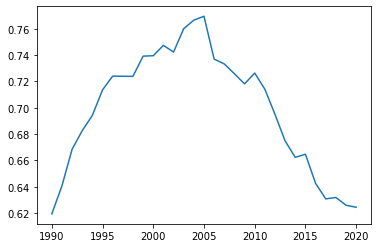

In [14]:
%matplotlib inline

df.Spain.plot();

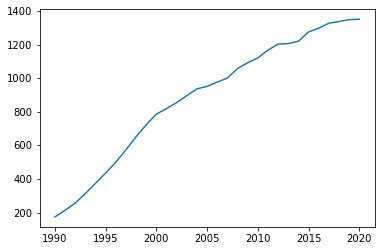

In [15]:
df.Colombia.plot();

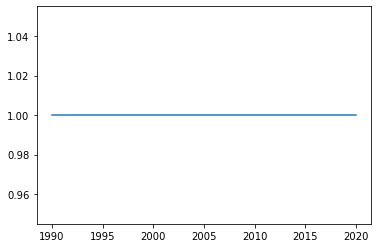

In [16]:
df['United States'].plot();

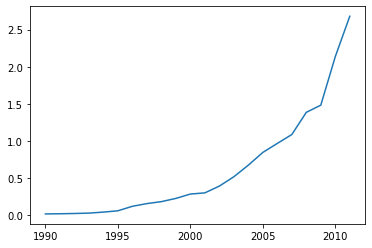

In [17]:
df['Venezuela, RB'].plot();

In [18]:
#arma 1 1 

# Fill null values

In [19]:
df=df.fillna(method='backfill')

In [20]:
df.index = pd.to_numeric(df.index, errors='coerce')

In [21]:
for i in df:
    df[i]=df[i].interpolate(method="spline", order=1)

# Modeling

In [22]:
# ARMA order==> p=>AR(n, maxlag), q=MA(m, ancho de la ventana)

from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error as mse

In [23]:
db = df.reset_index()

In [24]:
db['index'] =  pd.to_datetime(db['index'], format='%Y')

In [25]:
db=db.set_index('index')

In [26]:
train, test = db.Spain[:-4], db.Spain[-4:]

In [27]:
model=ARMA(train, order = (1, 1)).fit(disp=False)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


In [28]:
pred=model.predict(len(train), len(db.Spain)-1)

In [29]:
pred

2017-01-01    0.636340
2018-01-01    0.637718
2019-01-01    0.639021
2020-01-01    0.640253
Freq: AS-JAN, dtype: float64

In [30]:
mse(model.predict(len(train), len(db.Spain)-1), test)**0.5

0.010965728888099387

In [31]:
pred=model.predict(len(train), len(db.Spain)-1)
error=(pred-test).abs().sum()/len(pred)
print('Error mae: ', error.round(5))
res=pd.DataFrame({'real': test, 'pred': pred, 'diff':pred-test})
res

Error mae:  0.01001


,real,pred,diff
2017-01-01,0.630839,0.636340,0.005501
2018-01-01,0.631944,0.637718,0.005774
2019-01-01,0.626031,0.639021,0.012990
2020-01-01,0.624484,0.640253,0.015769


In [32]:
train, test = db.Spain[:-4], db.Spain[-4:]

In [33]:
model=ARMA(train, order = (1, 1)).fit(disp=False)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


In [34]:
pred=model.predict(len(train), len(db.Spain)-1)

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

In [36]:
db=db.append(pd.Series(name='2021-01-01 00:00:00'))
db=db.append(pd.Series(name='2022-01-01 00:00:00'))
db=db.append(pd.Series(name='2023-01-01 00:00:00'))

In [37]:
import warnings 
warnings.simplefilter('ignore')
for j in db:
        train, test = db[j][:-3], db[j][-3:]
        model=SARIMAX(train, order = (1, 1, 1)).fit(disp=False)
        pred=model.predict(len(train), len(db[j])-1)
        db[j].iloc[-3]=pred[2]
        db[j].iloc[-2]=pred[1]
        db[j].iloc[-1]=pred[0]

In [62]:
train, test = db[j][:-3], db[j][-3:]
model=SARIMAX(train, order = (1, 1, 1)).fit(disp=False)
pred=model.predict(len(train), len(db[j])-1)
pred

2021-01-01    0.471925
2022-01-01    0.472043
2023-01-01    0.472036
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [38]:
db

,Aruba,Afghanistan,Angola,Albania,United Arab Emirates,Argentina,Armenia,Antigua and Barbuda,Australia,Austria,...,"Venezuela, RB",British Virgin Islands,Vietnam,Vanuatu,Samoa,Kosovo,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
index,,,,,,,,,,,,,,,,,,,,,
1990-01-01 00:00:00,0.945131,9.190297,1.058393e-08,2.338549,1.167017,0.293643,0.005126,1.758677,1.365519,0.922246,...,0.012092,1.027547,672.445994,76.451643,0.744092,0.330570,6.107839,1.265262,0.009556,0.743998
1991-01-01 00:00:00,0.965522,9.190297,2.112144e-08,3.065402,1.137996,0.683117,0.008895,1.745487,1.348412,0.924566,...,0.014205,1.027547,1122.326898,81.543964,0.763738,0.330570,6.616785,1.415433,0.017809,0.670887
1992-01-01 00:00:00,0.979811,9.190297,1.190553e-07,9.979887,1.132743,0.775240,0.058162,1.748599,1.328550,0.935415,...,0.017812,1.027547,1455.366541,81.948397,0.810685,0.330570,7.321481,1.585498,0.046234,0.563257
1993-01-01 00:00:00,1.007829,9.190297,1.183680e-06,21.998489,1.120668,0.730329,0.847218,1.739101,1.312794,0.938959,...,0.022906,1.027547,1669.268603,81.702942,0.797107,0.330570,8.323239,1.749861,0.110046,0.529361
1994-01-01 00:00:00,1.048954,9.190297,2.637706e-05,29.258513,1.094358,0.735435,34.899729,1.757988,1.301014,0.942540,...,0.036531,1.027547,1911.431980,81.842870,1.312921,0.330570,9.842986,1.877083,0.194742,0.498103
1995-01-01 00:00:00,1.062042,9.190297,4.974581e-04,31.477205,1.113766,0.743130,89.273584,1.763266,1.310865,0.939929,...,0.054301,1.027547,2191.198000,81.550365,1.196255,0.330570,14.050874,2.026311,0.249130,0.502697
1996-01-01 00:00:00,1.077156,9.190297,2.393975e-02,35.424557,1.156881,0.729385,104.844131,1.783113,1.312182,0.936118,...,0.114927,1.027547,2338.934770,81.753910,1.228667,0.330570,18.871843,2.147189,0.304221,0.538010
1997-01-01 00:00:00,1.098135,9.190297,4.599778e-02,38.738167,1.126440,0.713695,121.346788,1.784917,1.308112,0.931829,...,0.151332,1.027547,2450.979298,82.921362,1.350804,0.330570,21.016099,2.279385,0.375034,0.513663
1998-01-01 00:00:00,1.157248,9.190297,6.338876e-02,40.720081,1.066513,0.693716,132.833997,1.802291,1.300300,0.922801,...,0.177917,1.027547,2637.903378,88.687148,1.381368,0.330570,19.049449,2.429536,0.433561,0.370553


# Adapt data and add currency codes

In [39]:
forecast=db.T

In [40]:
forecast

index,1990-01-01 00:00:00,1991-01-01 00:00:00,1992-01-01 00:00:00,1993-01-01 00:00:00,1994-01-01 00:00:00,1995-01-01 00:00:00,1996-01-01 00:00:00,1997-01-01 00:00:00,1998-01-01 00:00:00,1999-01-01 00:00:00,...,2014-01-01 00:00:00,2015-01-01 00:00:00,2016-01-01 00:00:00,2017-01-01 00:00:00,2018-01-01 00:00:00,2019-01-01 00:00:00,2020-01-01 00:00:00,2021-01-01 00:00:00,2022-01-01 00:00:00,2023-01-01 00:00:00
Aruba,9.451314e-01,9.655218e-01,9.798110e-01,1.007829,1.048954,1.062042,1.077156,1.098135,1.157248,1.165873,...,1.308843,1.362318,1.355045,1.350690,1.409705,1.424593,1.439480,1.455043,1.452454,1.459687
Afghanistan,9.190297e+00,9.190297e+00,9.190297e+00,9.190297,9.190297,9.190297,9.190297,9.190297,9.190297,9.190297,...,17.035878,17.022520,17.445828,17.205558,17.144309,17.914483,18.927627,19.393423,19.372971,19.287213
Angola,1.058393e-08,2.112144e-08,1.190553e-07,0.000001,0.000026,0.000497,0.023940,0.045998,0.063389,0.410850,...,65.000671,68.182045,80.778969,92.951721,117.116076,146.167168,174.713839,248.139497,225.226384,200.785136
Albania,2.338549e+00,3.065402e+00,9.979887e+00,21.998489,29.258513,31.477205,35.424557,38.738167,40.720081,41.101613,...,42.893807,42.705831,42.385879,42.255535,42.125796,41.342391,41.497269,42.474337,42.308328,42.015124
United Arab Emirates,1.167017e+00,1.137996e+00,1.132743e+00,1.120668,1.094358,1.113766,1.156881,1.126440,1.066513,1.140101,...,2.182567,2.187785,2.189752,2.221792,2.346952,2.258503,2.389256,2.381453,2.381787,2.380031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kosovo,3.305701e-01,3.305701e-01,3.305701e-01,0.330570,0.330570,0.330570,0.330570,0.330570,0.330570,0.330570,...,0.339622,0.339128,0.339378,0.340077,0.335354,0.332390,0.325307,0.328527,0.328377,0.327769
"Yemen, Rep.",6.107839e+00,6.616785e+00,7.321481e+00,8.323239,9.842986,14.050874,18.871843,21.016099,19.049449,25.062039,...,100.240249,106.388002,112.535755,118.683507,124.831260,130.979012,137.126765,154.179036,148.553185,142.869294
South Africa,1.265262e+00,1.415433e+00,1.585498e+00,1.749861,1.877083,2.026311,2.147189,2.279385,2.429536,2.563279,...,5.571891,5.825256,6.159093,6.426701,6.519588,6.652566,6.609416,6.651762,6.638367,6.624265
Zambia,9.556399e-03,1.780860e-02,4.623424e-02,0.110046,0.194742,0.249130,0.304221,0.375034,0.433561,0.503995,...,3.064822,3.366482,3.878827,4.192580,4.396237,4.641657,4.098580,3.315622,3.515256,3.770987


In [41]:
forecast['Country'] = forecast.index

In [42]:
forecast

index,1990-01-01 00:00:00,1991-01-01 00:00:00,1992-01-01 00:00:00,1993-01-01 00:00:00,1994-01-01 00:00:00,1995-01-01 00:00:00,1996-01-01 00:00:00,1997-01-01 00:00:00,1998-01-01 00:00:00,1999-01-01 00:00:00,...,2015-01-01 00:00:00,2016-01-01 00:00:00,2017-01-01 00:00:00,2018-01-01 00:00:00,2019-01-01 00:00:00,2020-01-01 00:00:00,2021-01-01 00:00:00,2022-01-01 00:00:00,2023-01-01 00:00:00,Country
Aruba,9.451314e-01,9.655218e-01,9.798110e-01,1.007829,1.048954,1.062042,1.077156,1.098135,1.157248,1.165873,...,1.362318,1.355045,1.350690,1.409705,1.424593,1.439480,1.455043,1.452454,1.459687,Aruba
Afghanistan,9.190297e+00,9.190297e+00,9.190297e+00,9.190297,9.190297,9.190297,9.190297,9.190297,9.190297,9.190297,...,17.022520,17.445828,17.205558,17.144309,17.914483,18.927627,19.393423,19.372971,19.287213,Afghanistan
Angola,1.058393e-08,2.112144e-08,1.190553e-07,0.000001,0.000026,0.000497,0.023940,0.045998,0.063389,0.410850,...,68.182045,80.778969,92.951721,117.116076,146.167168,174.713839,248.139497,225.226384,200.785136,Angola
Albania,2.338549e+00,3.065402e+00,9.979887e+00,21.998489,29.258513,31.477205,35.424557,38.738167,40.720081,41.101613,...,42.705831,42.385879,42.255535,42.125796,41.342391,41.497269,42.474337,42.308328,42.015124,Albania
United Arab Emirates,1.167017e+00,1.137996e+00,1.132743e+00,1.120668,1.094358,1.113766,1.156881,1.126440,1.066513,1.140101,...,2.187785,2.189752,2.221792,2.346952,2.258503,2.389256,2.381453,2.381787,2.380031,United Arab Emirates
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kosovo,3.305701e-01,3.305701e-01,3.305701e-01,0.330570,0.330570,0.330570,0.330570,0.330570,0.330570,0.330570,...,0.339128,0.339378,0.340077,0.335354,0.332390,0.325307,0.328527,0.328377,0.327769,Kosovo
"Yemen, Rep.",6.107839e+00,6.616785e+00,7.321481e+00,8.323239,9.842986,14.050874,18.871843,21.016099,19.049449,25.062039,...,106.388002,112.535755,118.683507,124.831260,130.979012,137.126765,154.179036,148.553185,142.869294,"Yemen, Rep."
South Africa,1.265262e+00,1.415433e+00,1.585498e+00,1.749861,1.877083,2.026311,2.147189,2.279385,2.429536,2.563279,...,5.825256,6.159093,6.426701,6.519588,6.652566,6.609416,6.651762,6.638367,6.624265,South Africa
Zambia,9.556399e-03,1.780860e-02,4.623424e-02,0.110046,0.194742,0.249130,0.304221,0.375034,0.433561,0.503995,...,3.366482,3.878827,4.192580,4.396237,4.641657,4.098580,3.315622,3.515256,3.770987,Zambia


In [43]:
currency=pd.read_html('https://docs.1010data.com/1010dataReferenceManual/DataTypesAndFormats/currencyUnitCodes.html')
currency=currency[0]
currency['Entity']=currency['Entity'].str.lower()
forecast['Country']=forecast['Country'].str.lower()

In [44]:
currency

,Entity,Currency,Code,Minor Unit
0,afghanistan,Afghani,AFN,2
1,åland islands,Euro,EUR,2
2,albania,Lek,ALL,2
3,algeria,Algerian Dinar,DZD,2
4,american samoa,US Dollar,USD,2
...,...,...,...,...
273,zz07_no_currency,The codes assigned for transactions where no c...,XXX,N.A.
274,zz08_gold,Gold,XAU,N.A.
275,zz09_palladium,Palladium,XPD,N.A.
276,zz10_platinum,Platinum,XPT,N.A.


In [45]:
forecast_currency=forecast.merge(currency, left_on='Country', right_on='Entity')

In [46]:
forecast_currency=forecast_currency.drop(columns=['Minor Unit'])

In [47]:
forecast_currency.to_csv('/Users/mikel/Documents/Projects/chameleon-pricing/forecast_currency.csv', index=False)

# Model testing

In [48]:
train, test = db.Spain[:-3], db.Spain[-3:]
model=SARIMAX(train, order = (1, 1, 1)).fit(disp=False)
pred=model.predict(len(train), len(db.Spain)-1)
pred

2021-01-01    0.621920
2022-01-01    0.619767
2023-01-01    0.617959
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [49]:
mse(model.predict(len(train), len(db.Spain)-1), test)**0.5

0.0032348510487381983

In [50]:
pred=model.predict(len(train), len(db.Spain)-1)
error=(pred-test).abs().sum()/len(pred)
print('Error mae: ', error.round(5))
res=pd.DataFrame({'real': test, 'pred': pred, 'diff':pred-test})
res

Error mae:  0.00264


,real,pred,diff
2021-01-01 00:00:00,NaN,0.621920,0.003962
2022-01-01 00:00:00,NaN,0.619767,0.000000
2023-01-01 00:00:00,NaN,0.617959,-0.003962
2021-01-01 00:00:00,0.617959,NaN,NaN
2022-01-01 00:00:00,0.619767,NaN,NaN
2023-01-01 00:00:00,0.621920,NaN,NaN


# Forecast calculations

In [53]:
forecast_currency=pd.read_csv('/Users/mikel/Documents/Projects/chameleon-pricing/forecast_currency.csv')

In [54]:
def ppp_to_dollar(Code, last_value):
        conversion=convert(Code, 'usd', last_value)
        result = json.loads(conversion)
        return result['amount']
def ppp_to_spain(ppp_to_dollar):
    return round(ppp_to_dollar*1.35, 2)

In [55]:
def update_fc(value, code):
  dollar = ppp_to_dollar(code, value)
  adapted = ppp_to_spain(float(dollar))
  return adapted

In [ ]:
%%time
#for i in forecast_currency:
   # forecast_currency[i]=forecast_currency.apply(lambda x: update_fc(x[i], x['Code']),axis=1) 

In [ ]:
forecast_currency.drop(forecast_currency[forecast_currency['2023-01-01 00:00:00'] == 0.0].index, inplace = True)

In [ ]:
old = list(forecast_currency.columns)
res = []
for i in old:
  res.append(i.split('-'))

In [ ]:
new=[]
for j, e in enumerate(res):
  new.append(res[j][0])

In [ ]:
columns_new = dict(zip(old, new))

In [ ]:
forecast_currency = forecast_currency.rename(columns = columns_new)

In [ ]:
forecast_currency.set_index('Country', inplace=True)
forecast_currency.index.names = ['Year']
forecast_currency=forecast_currency.T
forecast_currency['Year'] = forecast_currency.index
forecast_currency.Year=pd.to_datetime(forecast_currency.Year)
forecast_currency.drop(forecast_currency.tail(3).index,inplace=True)

In [ ]:
#forecast_currency.to_excel('/Users/mikel/Documents/Projects/chameleon-pricing/price_forecast.xlsx', index=False)

# Nulls

In [ ]:
df=pd.read_excel('/Users/mikel/Documents/Projects/chameleon-pricing/price_forecast.xlsx')

In [ ]:
#fill old null values with first occurrence
df=df.fillna(method='backfill')

In [ ]:
for i in df:
    df[i]=df[i].interpolate(method="spline", order=1)

In [ ]:
df.to_excel('/Users/mikel/Documents/Projects/chameleon-pricing/price_forecast.xlsx', index=False)